## Setup

In [2]:
import torch
print(torch.__version__)
#import torchvision
#import torch.nn as nn

import os
import sys
import time

import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec

from data_loader import get_train_val_loader, get_test_loader
from autoencoder_helpers import *
from modules import *

from loss_functions import *
from model_testing import *
from adversarial_attacks import *
from modules import *
from data_loader import *

#GPU/CUDA setup
if torch.cuda.is_available():
    print("CUDA enabled!")
    device = torch.device('cuda:0')  # You can specify the index of the CUDA device you want to use
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # Specify the index of the GPU(s) you want to use
else:
    print("CUDA not available. Using CPU.")
    device = torch.device('cpu')
    
data_folder = 'data'
batch_size = 250
n_workers = 0
random_seed = 0

# download MNIST data
test_loader = get_test_loader(data_folder, batch_size, shuffle=True, num_workers=n_workers, pin_memory=True)

# download MNIST data
train_loader, val_loader = get_train_val_loader(data_folder, batch_size, random_seed, augment=False, val_size=0.2,
                           shuffle=True, show_sample=False, num_workers=0, pin_memory=True)

2.6.0
CUDA not available. Using CPU.


# Test and look inside the model on MNIST data

Load the model

In [3]:
paths = {"B30": "./saved_model/mnist_model/mnist_cae_balanced_clstsep_1500_0.002_250_True_0.0_20_1_1_1_1.0_0.0_30_4_32_1/mnist_cae00750.pth",
         "S30": "./saved_model/mnist_model/mnist_cae_standard_default_1500_0.002_250_False_0.5_20_1_1_1_0.8_0.2_30_4_32_1/mnist_cae00750.pth",
         "S15": "./saved_model/mnist_model/mnist_cae_standard_default_1500_0.002_250_False_0.5_20_1_1_1_0.8_0.2_15_4_32_1/mnist_cae00750.pth",
         "RS30": "./saved_model/mnist_model/mnist_cae_adversarial_standard_default_pdglinf_ce_20_0.3_0.02_True_1500_0.002_250_False_0.5_20_1_1_1_0.8_0.2_1.0_30_4_32_1/mnist_cae_adv00750.pth",
         "RB30": "./saved_model/mnist_model/mnist_cae_adversarial_balanced_clstsep_pdglinf_ce_20_0.3_0.02_True_800_0.002_250_True_0.0_20_1_1_1_1.0_0.0_1.0_30_4_32_1/mnist_cae_adv00750.pth",
         "FTB30n": "./saved_model/mnist_model/mnist_cae_FT_30_nothing_pdglinf_ce_20_0.3_0.02_True_20_0.002_250_20_1_1_1_1.0_0.0_1/mnist_cae_adv00020.pth",
         "FTB30a": "./saved_model/mnist_model/mnist_cae_FT_30_autoencoder_pdglinf_ce_20_0.3_0.02_True_20_0.002_250_20_1_1_1_1.0_0.0_1/mnist_cae_adv00020.pth",
         "FTB30p": "./saved_model/mnist_model/mnist_cae_FT_30_prototypes_pdglinf_ce_20_0.3_0.02_True_20_0.002_250_20_1_1_1_1.0_0.0_1/mnist_cae_adv00020.pth"}

s15 = torch.load(paths["S15"], weights_only=False)
s30 = torch.load(paths["S30"], weights_only=False)
b30 = torch.load(paths["B30"], weights_only=False)
#rs30 = torch.load(paths["RS30"], weights_only=False)
#rb30 = torch.load(paths["RB30"], weights_only=False)
#ftb30n = torch.load(paths["FTB30n"], weights_only=False)
#ftb30a = torch.load(paths["FTB30a"], weights_only=False)
#ftb30p = torch.load(paths["FTB30p"], weights_only=False)

s15.to(device)
s30.to(device)
b30.to(device)
#rs30.to(device)
#rb30.to(device)
#ftb30a.to(device)
#ftb30n.to(device)
#ftb30p.to(device)

print("MODELS LOADED")

MODELS LOADED


In [27]:
model = b30

In [28]:
n_classes = model.fc.linear.weight.size(0)
n_prototypes = model.fc.linear.weight.size(1)
input_height = 28         # MNIST data input shape
input_width = input_height

Show model prototypes

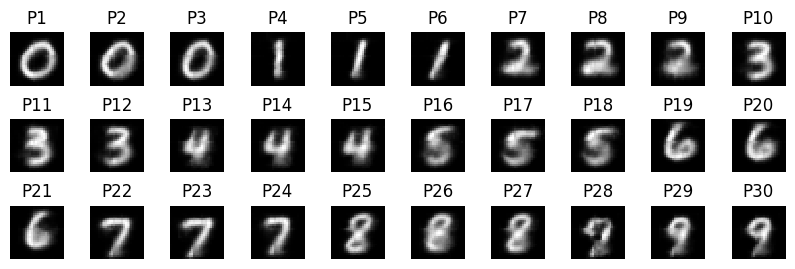

In [29]:
# visualize the prototype images
prototype_distances = model.prototype_layer.prototype_distances
prototype_imgs = model.decoder(prototype_distances.reshape((-1,10,2,2))).detach().cpu()

n_cols =10
n_rows = n_prototypes // n_cols + 1 if n_prototypes % n_cols != 0 else n_prototypes // n_cols
g, b = plt.subplots(n_rows, n_cols, figsize=(n_cols, n_rows))

# Ajuste del espacio entre subgráficos
plt.subplots_adjust(wspace=0.5, hspace=0.5)

for i in range(n_rows):
    for j in range(n_cols):
        if i*n_cols + j < n_prototypes:
            b[i][j].imshow(prototype_imgs[i*n_cols + j].reshape(input_height, input_width),
                            cmap='gray',
                            interpolation='none')
            b[i][j].axis('off')
            b[i][j].set_title(f'P{i*n_cols + j + 1}')
plt.show()

Decoding

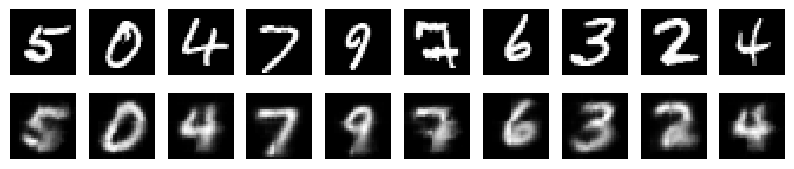

In [30]:
# Apply encoding and decoding over a small subset of the training set
batch_x = []
for batch in train_loader:
    batch_x = batch[0].to(device)
    break

examples_to_show = 10

encoded = model.encoder.forward(batch_x[:examples_to_show])
decoded = model.decoder.forward(encoded)

decoded = decoded.detach().cpu()
imgs = batch_x.detach().cpu()

# Compare original images to their reconstructions
f, a = plt.subplots(2, examples_to_show, figsize=(examples_to_show, 2))
for i in range(examples_to_show):
    a[0][i].imshow(imgs[i].reshape(input_height, input_width),
                   cmap='gray',
                   interpolation='none')
    a[0][i].axis('off')
    a[1][i].imshow(decoded[i].reshape(input_height, input_width), 
                   cmap='gray',
                   interpolation='none')
    a[1][i].axis('off')
                
plt.show()

Show model fc weights

In [31]:
rows = [f"P{i+1}" for i in range(n_prototypes)]
transposed_weights = model.fc.linear.weight.T.cpu().detach().numpy()    
df_weights = pd.DataFrame(transposed_weights, columns=range(n_classes), index=rows)

# Find the minimum value of each row
min_values = df_weights.min(axis=1)

# Highlight the minimum values in red
def highlight_min(s):
    is_min = s == s.min()
    return ['color: red' if v else '' for v in is_min]

# Apply the highlight_min function to the DataFrame
df_highlighted = df_weights.style.apply(highlight_min, axis=1)

df_highlighted


,0,1,2,3,4,5,6,7,8,9
P1,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
P2,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
P3,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
P4,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
P5,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
P6,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
P7,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
P8,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
P9,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
P10,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
